# 1D parameter estimation using maximum likelihood estimation

This example will cover:

 - Use maximum likelihood estimation to optimise kernel parameters

In [1]:
from gpvecchia.vecchia import GPtideVecchia
import numpy as np
import matplotlib.pyplot as plt

## Generate some data

Start off with the same kernel as Example 1 and generate some data.

`GPvecchia` only accepts covariance functions that use a distance matrix. 

In [2]:
from numba import njit

@njit(cache=True)
def expquad(d, l):
    """Exponential quadration base function/Squared exponential/RBF"""
    return np.exp(-d**2/(2*l**2))

In [3]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.5
η = 1.5
ℓ = 100
covfunc = expquad

###
# Domain size parameters
dx = 25.
N = 10000
covparams = (η, ℓ)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

# A re-ordering function should always be specified - the default is no re-ordering
order_func = np.random.permutation
order_params = len(xd)

GP = GPtideVecchia(xd, xd, noise, covfunc, covparams,\
                    order_func=order_func, order_params=order_params)

# Use the .prior() method to obtain some samples
yd = GP.sample_prior(samples=1, add_noise=True)

(25000.0, 49975.0)

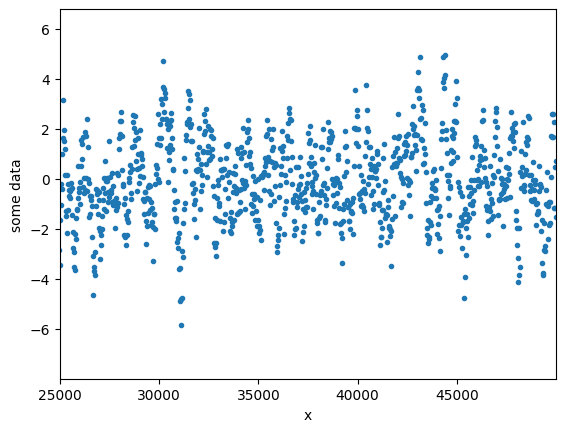

In [4]:
plt_ix = np.arange(1000,2000)
plt.figure()
plt.plot(xd, yd,'.')
plt.ylabel('some data')
plt.xlabel('x')
plt.xlim([xd[plt_ix[0]],xd[plt_ix[-1]]])

## Inference

We now use the `gptide.mle` function do the parameter estimation. This calls the `scipy.optimize.minimize` routine.


In [5]:
from gptide import mle

In [7]:
# Initial guess of the noise and covariance parameters (these can matter)
noise_ic = 0.1
covparams_ic = [1., 10.]

soln = mle(
    xd, yd, 
    covfunc, 
    covparams_ic,
    noise_ic,
    GPclass=GPtideVecchia,
    method='Nelder-Mead',
    gp_kwargs={'order_func':order_func, 'order_params':order_params, 'nnum':30},
    )

print('Noise (true): {:3.2f}, |Noise| (mle): {:3.2f}'.format(noise, abs(soln['x'][0])**2))
print('ℓ (true): {:3.2f}, ℓ (mle): {:3.2f}'.format(covparams[0], soln['x'][1]))
print('η (true): {:3.2f}, η (mle): {:3.2f}'.format(covparams[1], soln['x'][2]))

Noise (true): 0.50, |Noise| (mle): 0.57
ℓ (true): 1.50, ℓ (mle): 1.48
η (true): 100.00, η (mle): 99.20


Initial guesses can be important here. 

***More important is the optimisation method.*** It seems that Vecchia may introduce local minima causing gradient methods to get stuck. Increasing the number of neighbours can smooth this out, but for low numbers of neighbours (like the default 30), a method like Nelder-Mead seemed to work better, but can be slow.

***To do***: might be worth adding a tolerance kwarg to mle to end optimisation a bit quicker for big datasets. 